## Protocole 3 : Étude de la Synchronisation entre Triggers et Stimuli Visuels

Ce protocole vise à mesurer le délai et la gigue entre un trigger envoyé par une carte Arduino et l'apparition effective d'un stimulus visuel sur un écran.

### Prérequis

**Matériel :**
*   Tout le matériel des protocoles 1 et 2

**Logiciels :**
*   Tous les logiciels et bibliothèques des protocoles 1 et 2.

### Étapes à suivre

#### 1. Génération des Triggers et des Stimuli

1.  **Disposez de deux écrans** : un pour la fenêtre d’enregistrement (Waveforms) et l’autre pour l’affichage des stimuli visuels.

2.  **Préparez le code .ino et le code .py** associés. L'ensemble génère des triggers sur un pin (ici le pin 8) à chaque présentation de stimuli visuels, en prenant en argument la période désirée.

> **Code Arduino (.ino) pour la réception de commandes série.**
>
> ```arduino
> const int triggerPin = 8;
> 
> void setup() {
>     Serial.begin(115200);
>     pinMode(triggerPin, OUTPUT);
>     digitalWrite(triggerPin, LOW);
> }
> 
> void loop() {
>     if (Serial.available()) {
>         String cmd = Serial.readStringUntil('\n');
>         if (cmd == "TRIG") {
>             digitalWrite(triggerPin, HIGH);
>             delayMicroseconds(1000);  // 1 ms pulse
>             digitalWrite(triggerPin, LOW);
>         }
>     }
> }
> ```


3.  **Téléversez le code `.ino`** sur votre carte Arduino en suivant les étapes 2 à 5 du Protocole 1.

4.  **Préparez votre code Python (.py)** qui affiche les stimuli et envoie les commandes à l'Arduino.

> **Code Python (.py) pour l'affichage des stimuli et l'envoi des triggers.**
>
>     from expyriment import design, control, stimuli, misc
>     import serial
>     import time
>
>     # --- Setup Arduino ---
>     arduino = serial.Serial('/dev/ttyACM0', 115200)
>     time.sleep(2)  # Laisser le temps à l'Arduino de redémarrer
>
>     # --- Setup Expyriment ---
>     exp = design.Experiment(name="Stimuli_Trigger_Sync")
>     control.set_develop_mode(True)
>     control.initialize(exp)
>
>     PERIOD = 500  # Intervalle total en ms
>     SQUARE_DURATION = 100  # ms
>
>     square = stimuli.Rectangle((400, 400), position=(0, 0))
>     blank = stimuli.BlankScreen()
>     square.preload()
>     blank.preload()
>
>     exp.add_data_variable_names(['trial', 'stimulus_time', 'trigger_time'])
>
>     control.start(skip_ready_screen=True)
>     clock = misc.Clock()
>     clock2 = misc.Clock()
>     i = 1
>
>     while i <= 10000:
>         while (clock2.time < i * PERIOD - 3):
>             pass
>
>         stim_time = clock2.time + square.present(update=True)
>         arduino.write(b'TRIG\n')  # Envoi trigger TTL
>         trig_time = clock2.time
>
>         while (clock2.time - stim_time < SQUARE_DURATION - 3):
>             pass
>         blank.present(update=True)
>
>         exp.data.add([i, stim_time, trig_time])
>         i += 1
>         exp.keyboard.process_control_keys()
>
>     control.end()
>     arduino.close()


5.  **Lancez le code .py** sur le terminal de votre ordinateur.
> ![Screenshot from 2025-07-10 23-37-04.png](<attachment:Screenshot from 2025-07-10 23-37-04.png>)

6.  Vous devriez maintenant avoir une fenêtre présentant les stimuli. **Placez cette fenêtre sur l'écran secondaire**. La carte Arduino devrait maintenant générer des triggers sur le pin concerné.

#### 2. Mesure des Signaux

1.  **Connectez les sondes de l'oscilloscope :**
    *   **Canal 1 (Trigger Arduino) :**
        *   Broche GND de l'oscilloscope sur le GND de l'Arduino.
        *   Broche de mesure sur le **pin 8** de l'Arduino.
    *   **Canal 2 (Photodiode) :**
        *   Broche GND de l'oscilloscope sur le GND de la photodiode.
        *   Broche de mesure sur la sortie (Vout) de la photodiode.

2.  **Placez la photodiode** au niveau de la fenêtre où sont présentés les stimuli.

3.  Lancez l'acquisition avec le bouton **`Run`**. Vous devriez maintenant observer deux signaux sur Waveforms :
    *   **Canal 1 :** Un signal de pics/créneaux (triggers Arduino).
    *   **Canal 2 :** Un autre signal qui varie avec l'intensité lumineuse (photodiode).
    Les deux signaux doivent être des créneaux de même période, mais de rapport cyclique différent.
> ![Screenshot from 2025-07-10 23-37-21.png](<attachment:Screenshot from 2025-07-10 23-37-21.png>)

4.  **Ajustez les échelles**.
>![Screenshot from 2025-06-16 15-22-47.png](<attachment:Screenshot from 2025-06-16 15-22-47.png>)
#### 3. Enregistrement des Signaux

1.  Suivez la même procédure que dans les protocoles 1 et 2, en vous assurant d'enregistrer les deux canaux. Vous obtiendrez un fichier `.csv` à plusieurs colonnes.
> ![Screenshot from 2025-07-10 23-37-32.png](<attachment:Screenshot from 2025-07-10 23-37-32.png>)

#### 4. Analyse des Signaux

1.  **Préparez votre code Python** pour l'étude du fichier `.csv` à deux colonnes. Ce code doit détecter les pics sur les deux signaux et analyser les intervalles entre un front montant du trigger Arduino et le pic de la photodiode correspondant.

    > **Code Python (.py) pour l'analyse de synchronisation (Arduino et photodiode).**
    > ```python
    >
    >     import numpy as np
    >     import matplotlib
    >     matplotlib.use('Agg')
    >     import matplotlib.pyplot as plt
    >     from scipy.signal import find_peaks
    >     import os
    >
    >     # === Paramètres globaux ===
    >     NOM_FICHIER_CSV = 'expy_trigger_sync.csv'
    >     SAMPLING_RATE = 10000      # Hz
    >     DISTANCE_MIN_MS = 1.0      # ms
    >
    >     def analyser_signaux_csv(fichier_csv):
    >         try:
    >             data = np.loadtxt(fichier_csv, delimiter=',')
    >             if data.shape[1] < 2:
    >                 raise ValueError("Le fichier doit contenir au moins 2 colonnes (Arduino, Photodiode).")
    >
    >             ttl = data[:, 0]
    >             photodiode = data[:, 1]
    >
    >             # Seuils dynamiques (50% du max de chaque signal)
    >             seuil_ttl = 0.5 * np.max(ttl)
    >             seuil_photo = 0.5 * np.max(photodiode)
    >             print(f"Seuil TTL : {seuil_ttl:.2f}, Seuil Photodiode : {seuil_photo:.2f}")
    >
    >             min_distance_samples = int((DISTANCE_MIN_MS / 1000) * SAMPLING_RATE)
    >
    >             # Détection des pics
    >             ttl_peaks, _ = find_peaks(ttl, height=seuil_ttl, distance=min_distance_samples)
    >             photo_peaks, _ = find_peaks(photodiode, height=seuil_photo, distance=min_distance_samples)
    >
    >             # Intervalles intra-triggers
    >             def analyse_intervalles(peaks, label):
    >                 intervalles = np.diff(peaks) / SAMPLING_RATE * 1000  # ms
    >                 moyenne = np.mean(intervalles)
    >                 print(f"\n--- {label} ---")
    >                 print(f"Nombre de triggers : {len(peaks)}")
    >                 print(f"Intervalle moyen : {moyenne:.2f} ms")
    >                 print(f"Min : {np.min(intervalles):.2f}, Max : {np.max(intervalles):.2f}, Écart-type : {np.std(intervalles):.2f}")
    >
    >                 plt.figure(figsize=(10, 5))
    >                 plt.hist(intervalles, bins=40, edgecolor='black', alpha=0.8)
    >                 plt.axvline(moyenne, color='red', linestyle='--', label=f'Moyenne = {moyenne:.2f} ms')
    >                 plt.title(f'Intervalles entre triggers - {label}')
    >                 plt.xlabel("Durée (ms)")
    >                 plt.ylabel("Occurrences")
    >                 plt.legend()
    >                 os.makedirs('figures', exist_ok=True)
    >                 plt.savefig(f'figures/hist_intervalles_{label.lower().replace(" ", "_")}.png')
    >                 plt.close()
    >
    >             analyse_intervalles(ttl_peaks, "Arduino")
    >             analyse_intervalles(photo_peaks, "Photodiode")
    >
    >             # Délai Arduino -> Photodiode
    >             matched_delays = []
    >             for t in ttl_peaks:
    >                 deltas = photo_peaks - t
    >                 pos_deltas = deltas[deltas > 0]
    >                 if len(pos_deltas) > 0:
    >                     delay = pos_deltas[0] / SAMPLING_RATE * 1000
    >                     matched_delays.append(delay)
    >
    >             matched_delays = np.array(matched_delays)
    >             print("\n--- Délai entre trigger Arduino et détection visuelle ---")
    >             print(f"Nombre d'appariements : {len(matched_delays)}")
    >             print(f"Délai moyen : {np.mean(matched_delays):.2f} ms, Min : {np.min(matched_delays):.2f}, Max : {np.max(matched_delays):.2f}, Jitter : {np.std(matched_delays):.2f} ms")
    >
    >             plt.figure(figsize=(10, 5))
    >             plt.hist(matched_delays, bins=30, edgecolor='black', alpha=0.8)
    >             plt.axvline(np.mean(matched_delays), color='red', linestyle='--', label=f'Moyenne = {np.mean(matched_delays):.2f} ms')
    >             plt.title("Délai entre trigger Arduino et photodiode")
    >             plt.xlabel("Délai (ms)")
    >             plt.ylabel("Occurrences")
    >             plt.legend()
    >             plt.savefig('figures/delai_arduino_vs_photodiode.png')
    >             plt.close()
    >
    >         except Exception as e:
    >             print(f"Erreur : {e}")
    >
    >     if __name__ == '__main__':
    >         analyser_signaux_csv(NOM_FICHIER_CSV)
    > ```

2.  **Lancez le code**.
>![Screenshot from 2025-07-10 23-37-50.png](<attachment:Screenshot from 2025-07-10 23-37-50.png>)

3.  Vous avez désormais affiché sur le terminal les caractéristiques des deux signaux et celles des intervalles de latence, ainsi que les histogrammes correspondants que vous pouvez retrouver au chemin d'accès renseigné.
>![Screenshot from 2025-07-10 23-38-02.png](<attachment:Screenshot from 2025-07-10 23-38-02.png>)
>![Screenshot from 2025-07-10 23-38-12.png](<attachment:Screenshot from 2025-07-10 23-38-12.png>)
>![Screenshot from 2025-07-10 23-38-19.png](<attachment:Screenshot from 2025-07-10 23-38-19.png>)
>![Screenshot from 2025-07-10 23-38-26.png](<attachment:Screenshot from 2025-07-10 23-38-26.png>)
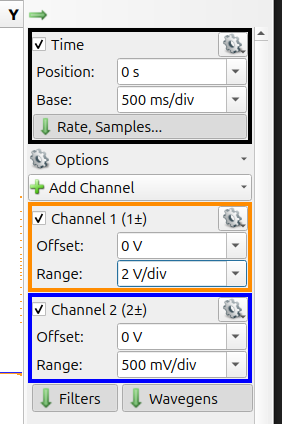
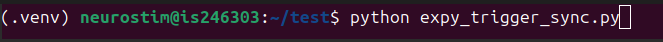
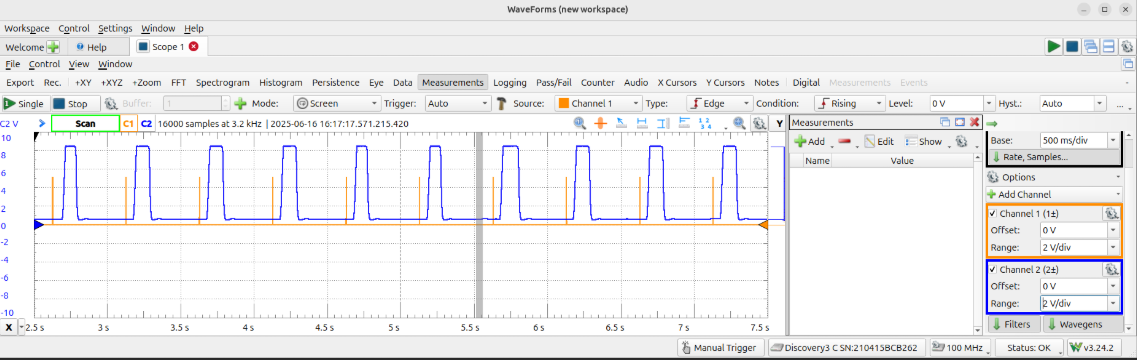
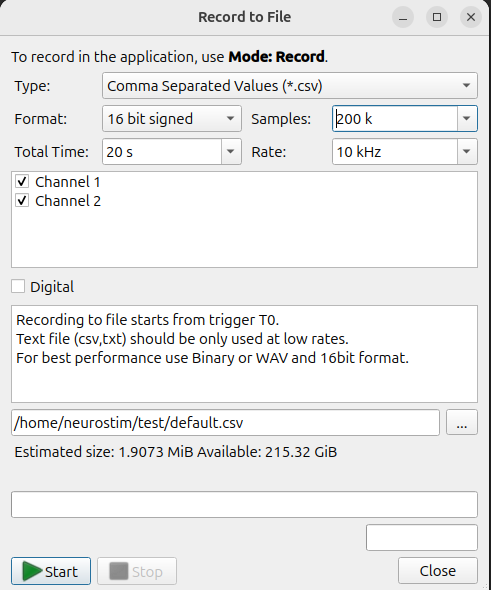
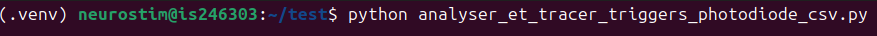
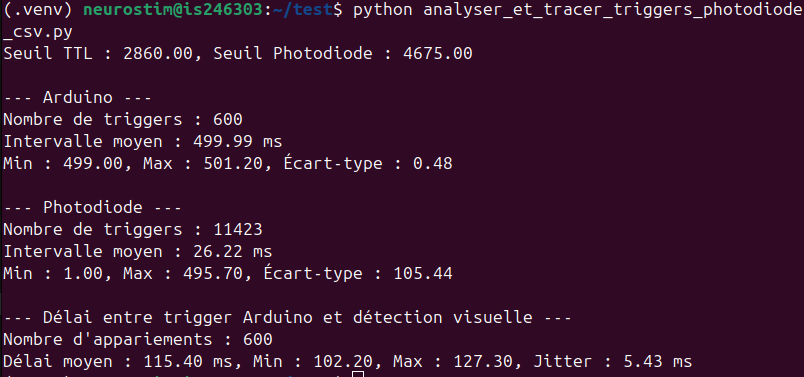
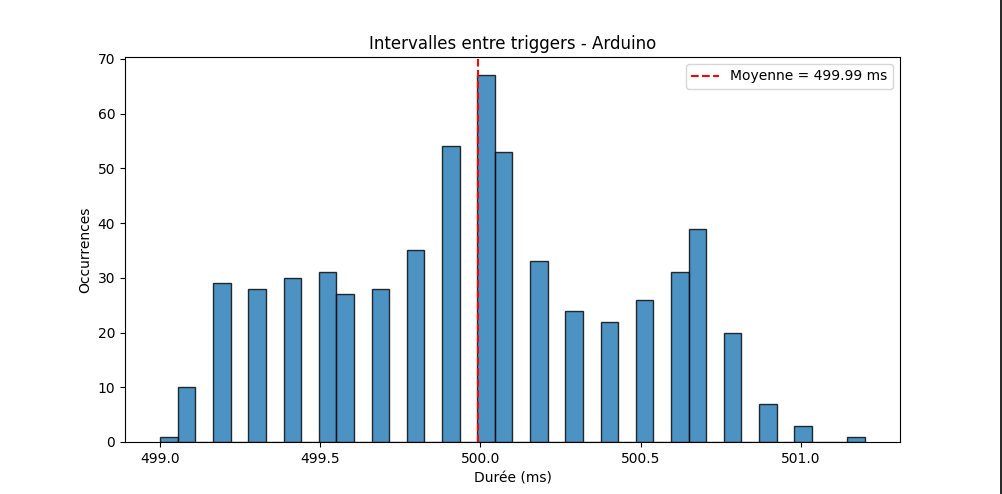
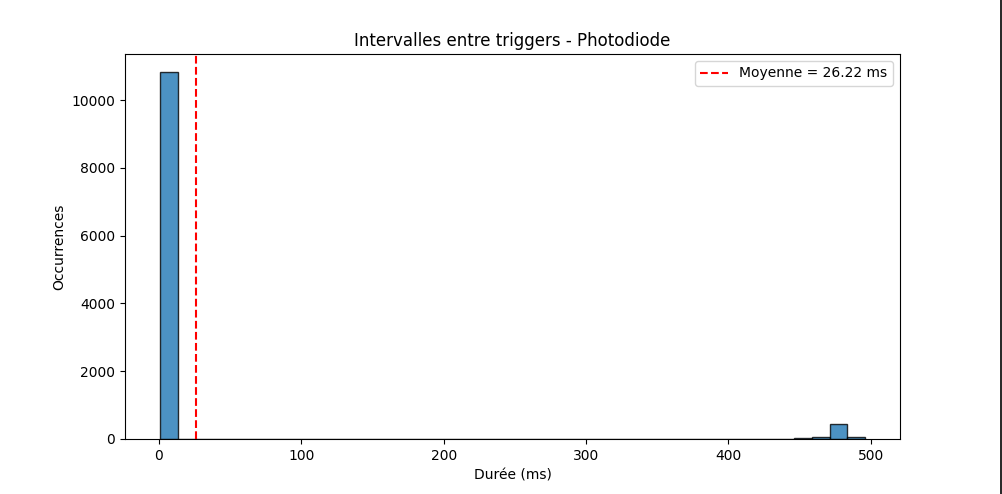
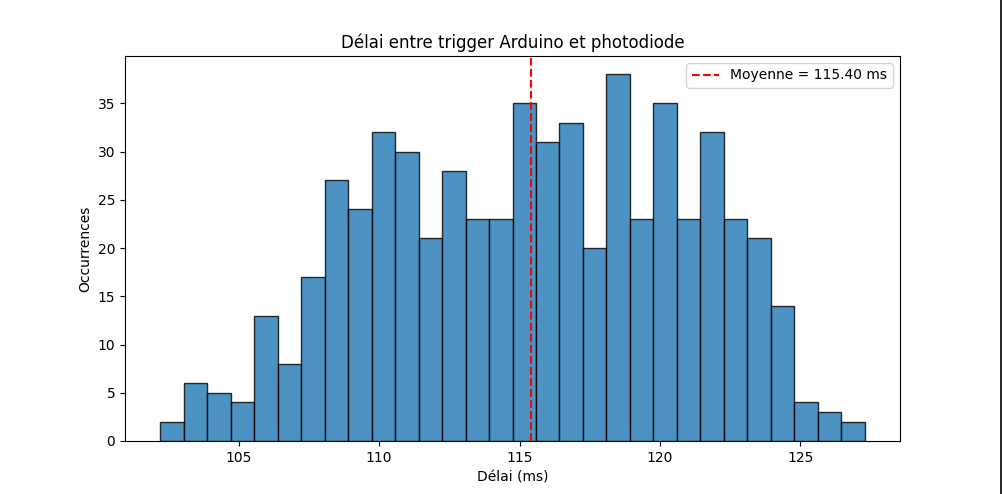